# Predicting the price of French wine

In [10]:
import os
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.api import OLS
from statsmodels.api import add_constant
import statsmodels.api as sm
from scipy.stats import norm, t

Download the pickle file named *wine_dataset_sql* from the repo and run this cell to read it:


In [6]:
df = pd.read_pickle('wine_dataset_sql')

In [7]:
df

,vintage_id,name,certified_biodynamic,wine_id,wine_name,type,is_natural,region_id,country,winery_id,...,contains_milk_allergens,contains_egg_allergens,closure,year,median_price,acidity,body,region,ratings_average,grapes
0,87141641,Penfolds Bin 407 Cabernet Sauvignon 2016,0.0,1241,Bin 407 Cabernet Sauvignon,Red,0,7.0,Australie,1305,...,0.0,0.0,None,2016.0,64.17,Élevée,Corsé,South Australia,4.20,Cabernet Sauvignon
1,86033798,Penfolds Bin 28 Kalimna Shiraz 2016,0.0,1244,Bin 28 Kalimna Shiraz,Red,0,397.0,Australie,1305,...,0.0,0.0,None,2016.0,38.50,Élevée,Très corsé,Barossa Valley,4.05,Shiraz/Syrah
2,150311800,Penfolds Bin 28 Kalimna Shiraz 2017,0.0,1244,Bin 28 Kalimna Shiraz,Red,0,397.0,Australie,1305,...,0.0,0.0,None,2017.0,37.50,Élevée,Très corsé,Barossa Valley,4.05,Shiraz/Syrah
3,14518231,Penfolds Bin 128 Shiraz 2015,NaN,1245,Bin 128 Shiraz,Red,0,398.0,Australie,1305,...,0.0,0.0,None,2015.0,33.54,Élevée,Très corsé,Coonawarra,4.00,Shiraz/Syrah
4,151021564,Penfolds Bin 311 Chardonnay 2017,0.0,1249,Bin 311 Chardonnay,White,0,1556.0,Australie,1305,...,0.0,0.0,None,2017.0,34.65,Élevée,Corsé,Tumbarumba,3.70,Chardonnay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3212,157708709,Donnafugata Sul Vulcano Etna Rosso 2016,NaN,6514155,Sul Vulcano Etna Rosso,Red,0,2814.0,Italie,3149,...,NaN,NaN,None,2016.0,24.00,Élevée,Corsé,Etna,3.80,Nerello Mascalese
3213,158577771,Mouton Cadet Héritage 2017,0.0,6689232,Héritage,Red,0,383.0,France,139072,...,1.0,1.0,None,2017.0,16.84,Élevée,Corsé,Bordeaux,3.60,Cabernet Sauvignon
3214,161552589,Moon Twist Sauvignon Blanc 2019,NaN,7199473,Sauvignon Blanc,White,0,732.0,Nouvelle-Zélande,263801,...,NaN,NaN,None,2019.0,9.85,Élevée,Léger,Marlborough,3.90,Sauvignon Blanc
3215,160652058,La Rioja Alta Viña Arana Gran Reserva 2012,NaN,7311113,Viña Arana Gran Reserva,Red,0,492.0,Espagne,2268,...,NaN,NaN,None,2012.0,35.00,Élevée,Corsé,Rioja,4.30,Tempranillo


# Data Cleaning

In [195]:
# Dropping pointless columns
df.drop(["appelation_id","contains_milk_allergens","contains_egg_allergens","closure","rank_percentile_country","rank_percentile_region",
              "rank_percentile_winery","rank_percentile_wine_type","rank_percentile_global", "ratings_distribution_1","ratings_distribution_2",
              "ratings_distribution_3","ratings_distribution_4","ratings_distribution_5","vintage_rank_percentile_country",
              "vintage_rank_percentile_region","vintage_rank_percentile_winery","vintage_rank_percentile_global"], axis=1, inplace=True)

In [196]:
# Focus on French wines only
df = df.loc[df.country=='France']

In [197]:
# Dealing with null values in df
df.isna().sum() # Checking how many values in which column

vintage_id                     0
name                           0
certified_biodynamic        2221
wine_id                        0
wine_name                      0
type                           0
is_natural                     0
region_id                      0
country                        0
winery_id                      0
wine_description            1095
alcohol                      376
body_id                        0
acidity_id                     0
awards_number                  0
awards_bronze_number           0
awards_silver_number           0
awards_gold_number             0
awards_excellent_number        0
awards_platinum_number         0
awards_remarkable_number       0
awards_commended_number        0
contains_added_sulfites     1675
year                           0
median_price                   0
acidity                        0
body                           0
region                         0
ratings_average                0
grapes                         0
dtype: int

In [198]:
df.alcohol.fillna(df.alcohol.mean(), inplace=True) # Replacing missing values by mean in alcohol column.
df.certified_biodynamic.fillna(0, inplace=True) # Replacing missing values by 0 in certified_biodynamic column.
df.wine_description.fillna('', inplace=True) 
df.contains_added_sulfites.fillna(((df.certified_biodynamic==0)&(df.is_natural==0)).astype(int), inplace=True)
# Replacing missing values by 1 in contains_added_sulfites column,
# if both certified_biodynamic and is_natural are equal to 0, else replacing by 0.

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [199]:
df.isna().sum()

vintage_id                  0
name                        0
certified_biodynamic        0
wine_id                     0
wine_name                   0
type                        0
is_natural                  0
region_id                   0
country                     0
winery_id                   0
wine_description            0
alcohol                     0
body_id                     0
acidity_id                  0
awards_number               0
awards_bronze_number        0
awards_silver_number        0
awards_gold_number          0
awards_excellent_number     0
awards_platinum_number      0
awards_remarkable_number    0
awards_commended_number     0
contains_added_sulfites     0
year                        0
median_price                0
acidity                     0
body                        0
region                      0
ratings_average             0
grapes                      0
dtype: int64

In [200]:
df.drop_duplicates(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [201]:
# Check if there are still duplicates
df.vintage_id.nunique() == df.shape[0]

True

In [202]:
# Formatting data from the dataframe
df.year = df.year.astype(int)
df.awards_number = df.awards_number.astype(int)
df.certified_biodynamic = df.certified_biodynamic.astype(int)
df.is_natural = df.is_natural.astype(int)
df.region_id = df.region_id.astype(int)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [203]:
df_copy = df.copy()

## Exploratory Data Analysis: Visualization

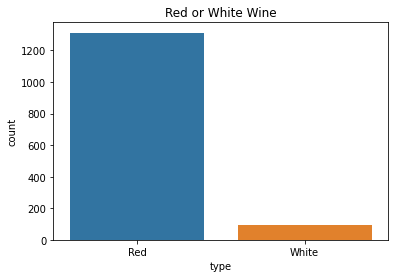

In [13]:
sns.countplot(x=df.type, data=df)
plt.title("Red or White Wine")
plt.show()

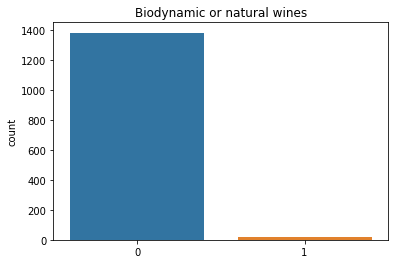

In [14]:
nat_or_biody = pd.Series(((df.certified_biodynamic == 1) | (df.is_natural == 1)).astype(int))

sns.countplot(x = nat_or_biody, data=df)
plt.title("Biodynamic or natural wines")
plt.show()

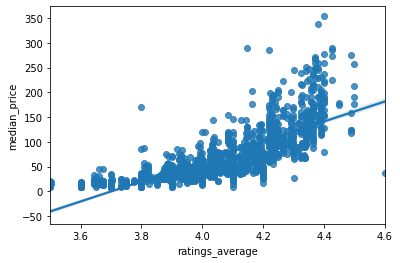

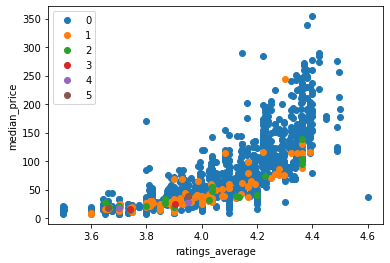

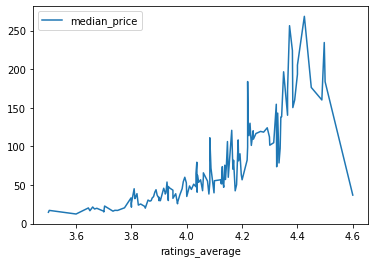

In [15]:
sns.regplot(x=df.ratings_average, y=df.median_price)
plt.show()

groups = df.groupby('awards_number')
for name, group in groups:
    plt.plot(group['ratings_average'], group['median_price'], marker='o', linestyle='', label=name)
plt.xlabel('ratings_average')
plt.ylabel('median_price')
plt.legend()
plt.show()

df[['ratings_average', 'median_price']].groupby('ratings_average').mean().plot()
plt.show()

We suspect a quadratic relation (increasing) between the *median_price* and the *ratings_average* (increasing): the better the ratings, the more expensive the wine will be.

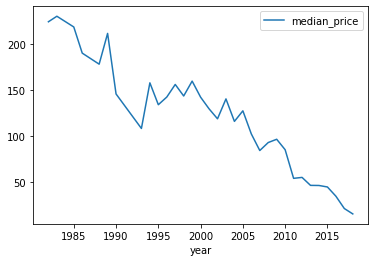

In [16]:
df[['year', 'median_price']].groupby('year').mean().plot()
plt.show()

We suspect a linear relation (decreasing) between the *median_price* and the *year*: the older the wine, the more expensive.

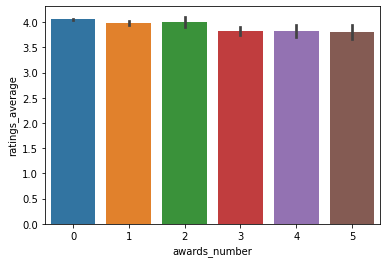

In [17]:
sns.barplot(x=df.awards_number, y=df.ratings_average)
plt.show()

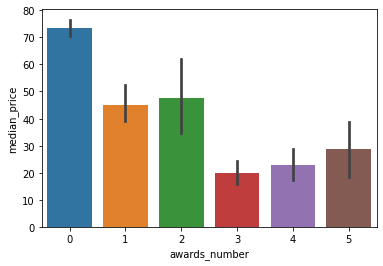

In [18]:
sns.barplot(x=df.awards_number, y=df.median_price)
plt.show()

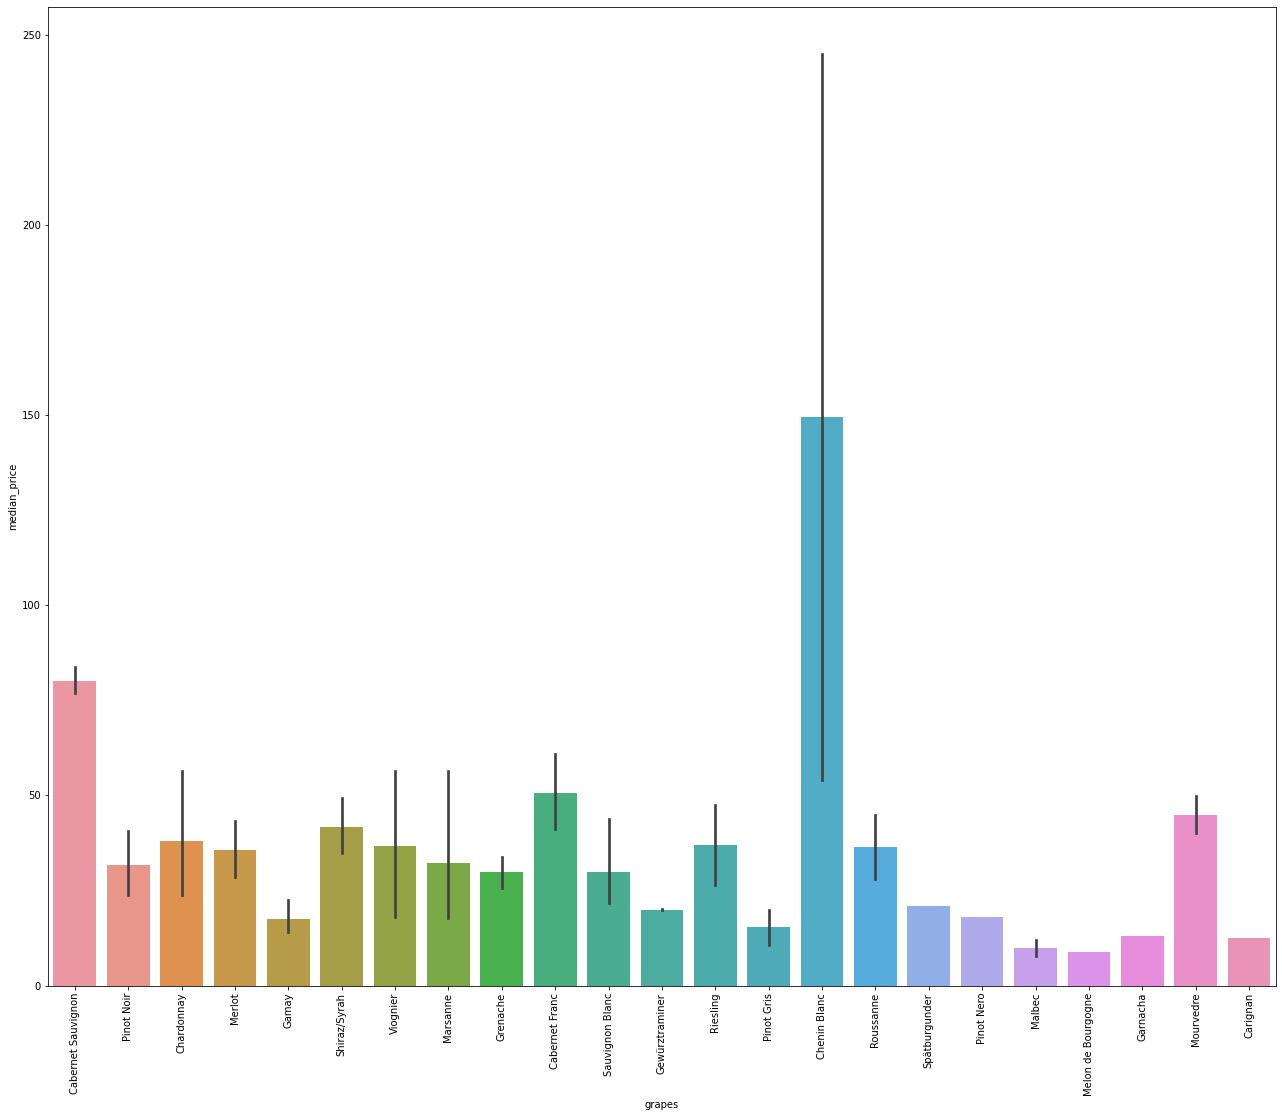

In [19]:
f, ax = plt.subplots(figsize=(22, 18))
sns.barplot(x=df.grapes, y=df.median_price)
plt.xticks(rotation=90)
plt.show()

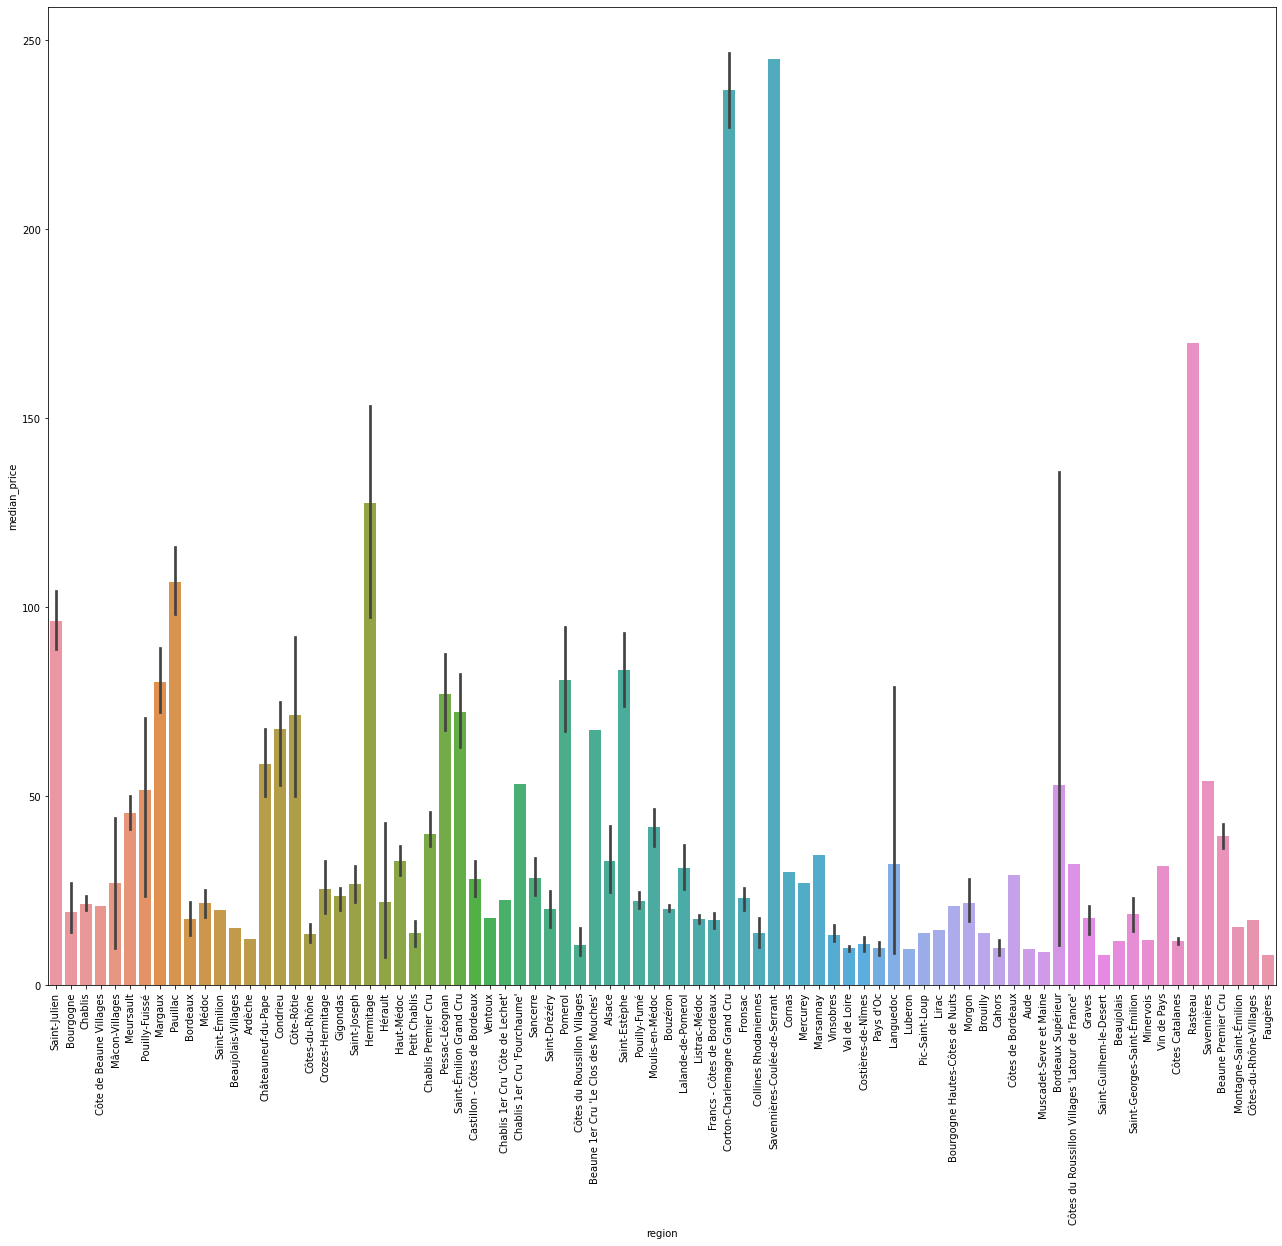

In [21]:
f, ax = plt.subplots(figsize=(22, 18))
sns.barplot(x=df.region, y=df.median_price)
plt.xticks(rotation=90)
plt.show()

# Descriptive Statistics


### Conventional vs natural or biodynamic wines 

In [9]:
df_nat = df[(df.certified_biodynamic==1) | (df.is_natural == 1)]
df_conv = df[(df.certified_biodynamic==0) & (df.is_natural == 0)]

In [42]:
# Checking the distribution of body in conventional and natural French wine
print('Distribution for conventional wines:\n',df_conv.body.value_counts()/df_conv.body.count()*100)
print('\nDistribution for natural wines:\n',df_nat.body.value_counts()/df_nat.body.count()*100)

Distribution for conventional wines:
 Corsé                79.428571
Très corsé           12.190476
Moyennement corsé     8.190476
Léger                 0.190476
Name: body, dtype: float64

Distribution for natural wines:
 Corsé                41.666667
Moyennement corsé    41.666667
Très corsé           16.666667
Name: body, dtype: float64


In [43]:
# Checking the distribution of acidity in natural French wine
print('Distribution for conventional wines:\n',df_conv.acidity.value_counts()/df_conv.acidity.count()*100)
print('\nDistribution for natural wines:\n',df_nat.acidity.value_counts()/df_nat.acidity.count()*100)

Distribution for conventional wines:
 Élevée     87.238095
Moyenne    12.190476
Faible      0.571429
Name: acidity, dtype: float64

Distribution for natural wines:
 Élevée     83.333333
Moyenne    16.666667
Name: acidity, dtype: float64


In [15]:
# Checking the difference of alcohol mean in conventional and natural French wine
print('Alcohol in conventional wine:', df_conv.alcohol.mean())
print('Alcohol in natural wine:', df_nat.alcohol.mean())

Alcohol in conventional wine: 13.797145593869732
Alcohol in natural wine: 13.295652173913044


# Inferential Statistics

### Confidence interval for the mean of prices 

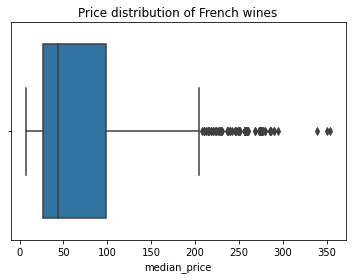

In [33]:
# Visualizing the distribution of prices in the dataset
sns.boxplot(x=df.median_price)
plt.title('Price distribution of French wines')
plt.show()

In [44]:
# Computing a confidence interval for the average price of French wine
price_mean = df.median_price.mean()
price_std = df.median_price.std()

print('Average price of the dataset is', price_mean)
print('Standard deviation in prices is', price_std)

Average price of the dataset is 71.46747280074604
Standard deviation in prices is 63.42248452849155


In [25]:
# Computing the confidence interval for the mean
def ci_norm(std, n):
    """ This function computes a confidence interval of the mean 
    using scipy"""
    standard_error = (std/(n**0.5))
    return norm.interval(0.95, scale=standard_error)

ci_mean = ci_norm(price_std, df.median_price.shape[0])
print('CI is -/+', ci_mean)

print(f'\nThe average price of French wine falls btw {round(price_mean+ci_mean[0], 1)} and {round(price_mean+ci_mean[1], 1)} with certainty 95%.')

CI is -/+ (-2.1916228095647794, 2.1916228095647794)

The average price of French wine falls btw 69.3 and 73.7 with certainty 95%.


## Hypothesis Testing 

## Difference in Population Proportions

### Research Question

#### Is French natural/biodynamic wine significantly more acidic than French conventionnal wine, on average ?


Populations: All conventional French wines ; all biodynamic and natural French wines

Parameter of Interest:  p1 proportion of wines with acidity "élevée" among conventional wines ; p2 proportion of wines with acidity "élevée" among biodynamic and natural wines. 

Null Hypothesis:  p1 = p2

Alternative Hypthosis:  p1 > p2

Data/sample: 14 biodynamic and natural French wines, a proportion p1 = 0.93 for biodynamic and natural wines with acidity "élevée" ; 215 conventional French wines, a proportion p2 = 0.81 for conventional wines with acidity "élevée".


### Use of ttest_ind() from statsmodels
Difference in population proportion needs t-test. Also, the population follow a binomial distribution here. We can just pass on the two population quantities with the appropriate binomial distribution parameters to the t-test function.

The function returns three values: (a) test statisic, (b) p-value of the t-test, and (c) degrees of freedom used in the t-test.

In [ ]:
# Proportion of acidity "Elevée" among biodynamic and natural wines
df[(df.certified_biodynamic == 1) | (df.is_natural == 1)].acidity.value_counts()/df[(df.certified_biodynamic == 1) | (df.is_natural == 1)].shape[0]

# Proportion of acidity "Elevée" among conventional wines
df[(df.certified_biodynamic == 0) & (df.is_natural == 0)].acidity.value_counts()/df[(df.certified_biodynamic == 0) & (df.is_natural == 0)].shape[0]


n1 = df[(df.certified_biodynamic == 1) | (df.is_natural == 1)].shape[0]
p1 = list(df[(df.certified_biodynamic == 1) | (df.is_natural == 1)].acidity.value_counts()/df[(df.certified_biodynamic == 1) | (df.is_natural == 1)].shape[0])[0]
p1 = round(p1, 2)

n2 = df[(df.certified_biodynamic == 0) & (df.is_natural == 0)].shape[0]
p2 = list(df[(df.certified_biodynamic == 0) & (df.is_natural == 0)].acidity.value_counts()/df[(df.certified_biodynamic == 0) & (df.is_natural == 0)].shape[0])[0]
p2 = round(p2, 2)

print('n1:', n1)
print('p1:', p1)
print('n2:', n2)
print('p2:', p2)


population1 = list((df[(df.certified_biodynamic == 1) | (df.is_natural == 1)].acidity == 'Élevée').astype(int))
population2 = list((df[(df.certified_biodynamic == 0) & (df.is_natural == 0)].acidity == 'Élevée').astype(int))


sm.stats.ttest_ind(population1, population2)

## Conclusion of the hypothesis test
Since the p-value is quite high ~0.43, we cannot reject the Null hypothesis in this case i.e. the difference in the population proportions are not statistically significant.

# Supervised learning
## Predicting the price of French wine with a regression model

## First models of regression with variables ratings and years

### Pre-processing

In [62]:
# Reload df if needed - security checkpoint 
df = df_copy.copy()

In [63]:
# Getting dummies
dummies = ['year']

In [64]:
# Defining a new dataset df_reg that will be used in linear regression
df_reg = pd.get_dummies(data=df, columns=dummies, drop_first=True)

In [65]:
df_reg

,vintage_id,name,certified_biodynamic,wine_id,wine_name,type,is_natural,region_id,country,winery_id,...,year_2009,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
73,23971659,Château du Glana Saint-Julien 2014,0,1874,Saint-Julien,Red,0,399,France,4250,...,0,0,0,0,0,1,0,0,0,0
74,3054919,Château du Glana Saint-Julien 2011,0,1874,Saint-Julien,Red,0,399,France,4250,...,0,0,1,0,0,0,0,0,0,0
75,16484833,Château du Glana Saint-Julien 2015,0,1874,Saint-Julien,Red,0,399,France,4250,...,0,0,0,0,0,0,1,0,0,0
78,151168372,Louis Jadot Bourgogne Couvent des Jacobins 2017,0,2816,Bourgogne Couvent des Jacobins,Red,0,385,France,1308,...,0,0,0,0,0,0,0,0,1,0
79,156719028,Louis Jadot Chablis 2018,0,2824,Chablis,White,0,428,France,1308,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,152437330,Clos de Bouard Dame de Boüard Montagne Saint-É...,0,5408054,Dame de Boüard Montagne Saint-Émilion,Red,0,2146,France,233243,...,0,0,0,0,0,0,0,1,0,0
3206,158497491,Delas Viognier Vin de Pays d'Oc 2018,0,5660764,Viognier Vin de Pays d'Oc,White,0,3003,France,7636,...,0,0,0,0,0,0,0,0,0,1
3209,156064973,Xavier Vignon Arcane XIX Le Soleil Côtes du Rh...,0,6065382,Arcane XIX Le Soleil Côtes du Rhône Villages,Red,0,2402,France,17370,...,0,0,0,0,0,0,1,0,0,0
3211,157491668,Château des Adouzes Le Tigre Faugères 2017,0,6316253,Le Tigre Faugères,Red,0,2389,France,23172,...,0,0,0,0,0,0,0,0,1,0


In [66]:
# Dropping pointless or object-type columns from df
df_reg.drop(['region','body', 'acidity','is_natural', 'certified_biodynamic', 'awards_number','alcohol', 'contains_added_sulfites','grapes','vintage_id', 'wine_id', 'winery_id', 'name', 'wine_name', 'type',  'region_id', 'country', 'wine_description', 
         'body_id','acidity_id', 'awards_bronze_number', 'awards_silver_number', 'awards_gold_number',
       'awards_excellent_number', 'awards_platinum_number',
       'awards_remarkable_number', 'awards_commended_number', ], axis=1, inplace=True)

In [67]:
X = df_reg.drop('median_price', axis=1)
y = df_reg.median_price

In [68]:
# Splitting train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                       test_size = 1/3,  
                                       random_state = 23, 
                                       shuffle = True)

In [69]:
# Normalizing features with MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

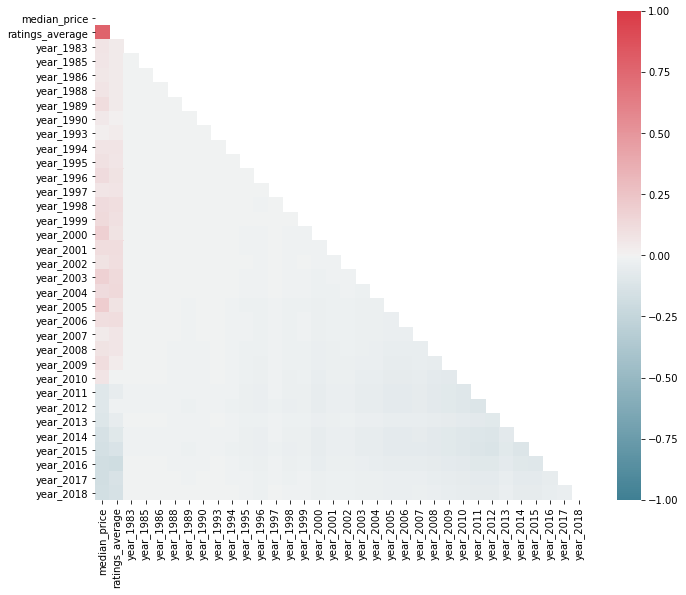

In [70]:
corr= df_reg.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, cmap=cmap, center=0)
plt.show()

### Linear Regression Model

In [71]:
# Finding the name of the columns
X_train = pd.DataFrame(X_train)
X_train.columns = df_reg.drop('median_price', axis=1).columns
X_train = pd.DataFrame(X_train)

X_test = pd.DataFrame(X_test)
X_test.columns = df_reg.drop('median_price', axis=1).columns
X_test = pd.DataFrame(X_test)

In [72]:
# Hunting high p_values:
high_p = ['year_1993','year_2010','year_2000', 'year_1999', 'year_1983', 'year_1985', 'year_1986', 'year_1988', 
          'year_1990', 'year_2008', 
          'year_1994', 'year_1995', 'year_1996',
          'year_1997', 'year_1997', 'year_1998', 
          'year_2005', 'year_2003']

In [73]:
# First model - Statsmodel
y=y_train
X=X_train.drop(high_p, axis=1)
X=X_train
model=OLS(y,add_constant(X))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     135.0
Date:                Wed, 30 Sep 2020   Prob (F-statistic):          3.85e-228
Time:                        09:40:31   Log-Likelihood:                -4571.2
No. Observations:                 936   AIC:                             9176.
Df Residuals:                     919   BIC:                             9259.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.1033      4.206      0.976      0.330      -4.152      12.358
ratings_average   193.9277      6.096     31.810      0.000     181.963     205.892
year_1989          88.5488     22.914      3.864      0.000      43.578     133.519
year_2001         -10.4840      8.627     -1.215      0.225     -27.414       6.446
year_2002         -23.9878     10.988     -2.183      0.029     -45.553      -2.423
year_2004         -21.2226      7.722     -2.748      0.006     -36.378      -6.068
year_2006         -17.5011      6.008     -2.913      0.004     -29.292      -5.710
year_2007         -28.5982      6.091     -4.695      0.000     -40.552     -16.645
year_2009         -10.8393      4.900     -2.212      0.027     -20.456      -1.222
year_2011         -44.2053      3.981    -11.104      0.000     -52.018     -36.393
year_2012         -43.6864      3.942    -11.081      0.000     -51.424     -35.949
year_2013         -46.0641      5.250     -8.774      0.000     -56.367     -35.761
year_2014         -47.6490      4.085    -11.664      0.000     -55.667     -39.631
year_2015         -44.0520      4.014    -10.974      0.000     -51.930     -36.174
year_2016         -39.5386      4.882     -8.100      0.000     -49.119     -29.958
year_2017         -55.0247      6.236     -8.823      0.000     -67.264     -42.785
year_2018         -56.3943      7.510     -7.510      0.000     -71.132     -41.656
==============================================================================
Omnibus:                      295.809   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1241.114
Skew:                           1.432   Prob(JB):                    3.13e-270
Kurtosis:                       7.860   Cond. No.                         25.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [74]:
df.head(50)

,vintage_id,name,certified_biodynamic,wine_id,wine_name,type,is_natural,region_id,country,winery_id,...,awards_remarkable_number,awards_commended_number,contains_added_sulfites,year,median_price,acidity,body,region,ratings_average,grapes
73,23971659,Château du Glana Saint-Julien 2014,0,1874,Saint-Julien,Red,0,399,France,4250,...,0,0,1.0,2014,25.42,Élevée,Corsé,Saint-Julien,3.866667,Cabernet Sauvignon
74,3054919,Château du Glana Saint-Julien 2011,0,1874,Saint-Julien,Red,0,399,France,4250,...,0,0,1.0,2011,29.96,Élevée,Corsé,Saint-Julien,3.866667,Cabernet Sauvignon
75,16484833,Château du Glana Saint-Julien 2015,0,1874,Saint-Julien,Red,0,399,France,4250,...,0,0,1.0,2015,29.00,Élevée,Corsé,Saint-Julien,3.866667,Cabernet Sauvignon
78,151168372,Louis Jadot Bourgogne Couvent des Jacobins 2017,0,2816,Bourgogne Couvent des Jacobins,Red,0,385,France,1308,...,0,0,1.0,2017,13.00,Élevée,Léger,Bourgogne,3.700000,Pinot Noir
79,156719028,Louis Jadot Chablis 2018,0,2824,Chablis,White,0,428,France,1308,...,0,0,1.0,2018,17.00,Élevée,Corsé,Chablis,3.800000,Chardonnay
80,3485129,Louis Jadot Côte de Beaune Villages 2013,0,2872,Côte de Beaune Villages,Red,0,2231,France,1308,...,0,0,1.0,2013,20.95,Élevée,Léger,Côte de Beaune Villages,3.500000,Pinot Noir
81,156522536,Louis Jadot Mâcon-Villages Blanc 2018,0,2906,Mâcon-Villages Blanc,White,0,2458,France,1308,...,0,0,1.0,2018,9.80,Moyenne,Moyennement corsé,Mâcon-Villages,3.800000,Chardonnay
82,20479528,Louis Jadot Meursault 2015,0,2923,Meursault,White,0,2246,France,1308,...,0,0,1.0,2015,50.00,Moyenne,Corsé,Meursault,4.200000,Chardonnay
83,156117324,Louis Jadot Pouilly-Fuissé 2018,0,2991,Pouilly-Fuissé,White,0,2264,France,1308,...,0,0,1.0,2018,23.50,Moyenne,Moyennement corsé,Pouilly-Fuissé,4.100000,Chardonnay
85,1380679,Château Rauzan-Ségla Margaux (Grand Cru Classé...,0,3110,Margaux (Grand Cru Classé),Red,0,384,France,3845,...,0,0,1.0,2006,105.00,Élevée,Corsé,Margaux,4.228571,Cabernet Sauvignon


### Prediction with linear regression (sklearn)

In [95]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model.coef_

array([ 1.87002210e+02,  3.03264859e+14, -1.53353718e+01, -4.38080281e+01,
       -3.91388204e+01,  1.63525004e+01, -3.55055844e+01, -9.06116719e+13,
       -9.14212842e+01, -6.76280634e+01, -6.34697822e+01, -7.41900477e+01,
       -7.15664366e+01, -4.33833191e+01, -4.79071295e+01, -8.21244151e+01,
       -9.55070440e+01, -5.86081983e+01, -9.30220519e+01, -5.83820905e+01,
       -8.98066551e+01, -1.01204862e+02, -9.04063937e+01, -8.37623351e+01,
       -8.63649664e+01, -1.17363476e+02, -1.16773283e+02, -1.19565560e+02,
       -1.21048936e+02, -1.17566120e+02, -1.13513507e+02, -1.28985421e+02,
       -1.30547187e+02])

In [96]:
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.7222517305172783
Test score: -8.392784428454981e+22


### Prediction with high p value removal

In [97]:
lr_model = LinearRegression()
lr_model.fit(X_train.drop(high_p, axis=1), y_train)

train_score = lr_model.score(X_train.drop(high_p, axis=1), y_train)
test_score = lr_model.score(X_test.drop(high_p, axis=1), y_test)
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.7015547383830008
Test score: 0.6965127288206685


### Prediction of the logarithm

In [98]:
lr_model = LinearRegression()
lr_model.fit(X_train.drop(high_p, axis=1), np.log(y_train))

train_score = lr_model.score(X_train.drop(high_p, axis=1), np.log(y_train))
test_score = lr_model.score(X_test.drop(high_p, axis=1), np.log(y_test))
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.8668187528665421
Test score: 0.8681743648669197


### Random Forest Regression

In [99]:
y_train = np.reshape(np.array(y_train), y_train.shape[0], )
y_test = np.reshape(np.array(y_test), y_test.shape[0], )

In [100]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(X_train, y_train)

train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.7101840078503493
Test score: 0.700807830317751


### Random Forest Regression with high p value removal

In [101]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(X_train.drop(high_p, axis=1), y_train)

train_score = rf_model.score(X_train.drop(high_p, axis=1), y_train)
test_score = rf_model.score(X_test.drop(high_p, axis=1), y_test)
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.7101840078503493
Test score: 0.700807830317751


### Random Forest Regression with logarithm

In [102]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(X_train.drop(high_p, axis=1), np.log(y_train))

train_score = rf_model.score(X_train.drop(high_p, axis=1), np.log(y_train))
test_score = rf_model.score(X_test.drop(high_p, axis=1), np.log(y_test))
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.7423777252880575
Test score: 0.7214313404844515


## Second models of regression with variables ratings and regions

### Pre-processing

In [103]:
# Reload df if needed - security checkpoint 
df = df_copy.copy()

In [ ]:
# For the linear reg purpose, keep only some regions of the dataset
region_to_keep = []
dct = dict(df.region_id.value_counts()>3)
for i in list(dct.keys()):
    if dct[i] == True:
        region_to_keep.append(i)
print(region_to_keep)

In [ ]:
# Add a new column where to store the regions that will be used with linear regression
df['region_to_keep'] = 0
count = 1
print('round', count)
for i in df.region_id:
    for j in region_to_keep:
        if i == j:
            df.region_to_keep[(df.region_id == i)] = i
print('The regions and their counts are:', dict(df.region_to_keep.value_counts()))

In [ ]:
# Dropping rows where values in col region_to_keep are 0
rows_to_drop = list(df[(df.region_to_keep == 0)].index)
df.drop(rows_to_drop, axis=0, inplace=True)
df.drop(['region_to_keep'], axis=1, inplace=True)

In [ ]:
# Getting dummies
dummies = []

dummies.append('region')

# Defining a new dataset df_reg that will be used in linear regression
df_reg = pd.get_dummies(data=df, columns=dummies, drop_first=True)

In [ ]:
# Dropping pointless or object-type columns from df
df_reg.drop(['year','body', 'acidity','is_natural', 'certified_biodynamic', 'awards_number','alcohol', 'contains_added_sulfites','grapes','vintage_id', 'wine_id', 'winery_id', 'name', 'wine_name', 'type',  'region_id', 'country', 'wine_description', 
         'body_id','acidity_id', 'awards_bronze_number', 'awards_silver_number', 'awards_gold_number',
       'awards_excellent_number', 'awards_platinum_number',
       'awards_remarkable_number', 'awards_commended_number'], axis=1, inplace=True)

In [ ]:
X = df_reg.drop('median_price', axis=1)
y = df_reg.median_price

In [ ]:
# Splitting train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                       test_size = 1/3,  
                                       random_state = 23, 
                                       shuffle = True)

In [ ]:
# Normalizing features and labels with MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Linear Regression Model

In [ ]:
# Finding the name of the columns
X_train = pd.DataFrame(X_train)
X_train.columns = df_reg.drop('median_price', axis=1).columns
X_train = pd.DataFrame(X_train)

X_test = pd.DataFrame(X_test)
X_test.columns = df_reg.drop('median_price', axis=1).columns
X_test = pd.DataFrame(X_test)

In [ ]:
# Hunting high p-values
high_p = ['region_Bourgogne','region_Bordeaux', 'region_Bordeaux Supérieur','region_Bouzéron', 
          'region_Castillon - Côtes de Bordeaux', 'region_Crozes-Hermitage', 
          'region_Côtes-du-Rhône', 'region_Graves', 'region_Haut-Médoc', 
          'region_Lalande-de-Pomerol', 'region_Listrac-Médoc', 'region_Margaux', 'region_Médoc', 
          'region_Pomerol', 'region_Saint-Estèphe', 'region_Saint-Joseph']

In [ ]:
# First model - Statsmodel
y=y_train
X=X_train.drop(high_p, axis=1)
model=OLS(y,add_constant(X))
model_fit=model.fit()
model_fit.summary()

In [ ]:
# Second model - Sickit-learn
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model.coef_

In [ ]:
lr_model.score(X_train, y_train)

In [ ]:
lr_model.score(X_test, y_test)

### Random Forest Regression

In [ ]:
X_train = X_train.drop(high_p, axis=1)
X_test =  X_test.drop(high_p, axis=1)

y_train = np.reshape(np.array(y_train), y_train.shape[0], )
y_test = np.reshape(np.array(y_test), y_test.shape[0], )

rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(X_train, y_train)
rf_model.score(X_train, y_train)

In [ ]:
rf_model.score(X_test, y_test)

## Third models of regression with variable ratings and grapes

### Pre-processing

In [ ]:
# Reload df if needed - security checkpoint 
df = df_copy.copy()

In [ ]:
# Getting dummies
dummies = []
dummies.append('grapes')

# Defining a new dataset df_reg that will be used in linear regression
df_reg = pd.get_dummies(data=df, columns=dummies, drop_first=True)

In [ ]:
# Dropping pointless or object-type columns from df
df_reg.drop(['year','region','body', 'acidity','is_natural', 'certified_biodynamic', 'awards_number','alcohol', 'contains_added_sulfites','vintage_id', 'wine_id', 'winery_id', 'name', 'wine_name', 'type',  'region_id', 'country', 'wine_description', 
         'body_id','acidity_id', 'awards_bronze_number', 'awards_silver_number', 'awards_gold_number',
       'awards_excellent_number', 'awards_platinum_number',
       'awards_remarkable_number', 'awards_commended_number', ], axis=1, inplace=True)

In [ ]:
X = df_reg.drop('median_price', axis=1)
y = df_reg.median_price

In [ ]:
# Splitting train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                       test_size = 1/3,  
                                       random_state = 23, 
                                       shuffle = True)

In [ ]:
# Normalizing features and labels with MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Linear Regression Model

In [ ]:
# Finding the name of the columns
X_train = pd.DataFrame(X_train)
X_train.columns = df_reg.drop('median_price', axis=1).columns

X_test = pd.DataFrame(X_test)
X_test.columns = df_reg.drop('median_price', axis=1).columns

In [ ]:
# Hunting high p_values:
X_train.columns
high_p = ['grapes_Cabernet Sauvignon', 'grapes_Carignan', 'grapes_Gamay', 'grapes_Garnacha', 
          'grapes_Gewürztraminer', 'grapes_Grenache', 'grapes_Malbec', 'grapes_Marsanne', 'grapes_Marsanne',
         'grapes_Melon de Bourgogne', 'grapes_Mourvedre', 'grapes_Pinot Gris', 'grapes_Pinot Nero', 'grapes_Pinot Noir', 
         'grapes_Riesling', 'grapes_Spätburgunder', 'grapes_Viognier']

In [ ]:
# First model - Statsmodel
y=y_train
X=X_train.drop(high_p, axis=1)
model=OLS(y,add_constant(X))
model_fit=model.fit()
model_fit.summary()

In [ ]:
# Second model - Sickit-learn
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_model.coef_

In [ ]:
lr_model.score(X_train, y_train)

In [ ]:
lr_model.score(X_test, y_test)

### Random Forest Regression

In [ ]:
X_train = X_train.drop(high_p, axis=1)
X_test =  X_test.drop(high_p, axis=1)

In [ ]:
y_train = np.reshape(np.array(y_train), y_train.shape[0], )
y_test = np.reshape(np.array(y_test), y_test.shape[0], )

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(X_train, y_train)
rf_model.score(X_train, y_train)

In [ ]:
rf_model.score(X_test, y_test)

## Wrapping up the variables together (ratings, years, regions, grapes) in a model of regression

In [104]:
df = df_copy.copy()

In [114]:
# For the linear reg purpose, keep only some regions of the dataset
region_to_keep = list(df.region_id.value_counts()[df.region_id.value_counts()>3].index)
print(region_to_keep)

[399, 393, 384, 456, 471, 427, 827, 555, 401, 3244, 417, 429, 607, 383, 387, 428, 635, 439, 423, 535, 386, 644, 385, 693, 2259, 451, 759, 738]


In [115]:
# Add a new column where to store the regions that will be used with linear regression
df['region_to_keep'] = 0
count = 1
print('round', count)
for i in df.region_id:
    for j in region_to_keep:
        if i == j:
            df.region_to_keep[(df.region_id == i)] = i
print('The regions and their counts are:', dict(df.region_to_keep.value_counts()))

round 1


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

The regions and their counts are: {399: 207, 393: 188, 384: 164, 456: 125, 471: 118, 427: 113, 827: 99, 0: 92, 555: 51, 401: 41, 3244: 28, 417: 24, 429: 23, 607: 16, 387: 13, 383: 13, 428: 12, 635: 10, 386: 8, 535: 8, 644: 8, 423: 8, 439: 8, 385: 6, 693: 5, 451: 4, 738: 4, 759: 4, 2259: 4}


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A

In [117]:
# Dropping rows where values in col region_to_keep are 0
rows_to_drop = list(df[(df.region_to_keep == 0)].index)
df.drop(rows_to_drop, axis=0, inplace=True)
df.drop(['region_to_keep'], axis=1, inplace=True)

In [118]:
# Getting dummies
dummies = []

dummies.append('year')
dummies.append('region')
dummies.append('grapes')


# Defining a new dataset df_reg that will be used in linear regression
df_reg = pd.get_dummies(data=df, columns=dummies, drop_first=True)

In [119]:
# Dropping pointless or object-type columns from df
df_reg.drop(['body', 'acidity','is_natural', 'certified_biodynamic', 'awards_number','alcohol', 'contains_added_sulfites','vintage_id', 'wine_id', 'winery_id', 'name', 'wine_name', 'type',  'region_id', 'country', 'wine_description', 
         'body_id','acidity_id', 'awards_bronze_number', 'awards_silver_number', 'awards_gold_number',
       'awards_excellent_number', 'awards_platinum_number',
       'awards_remarkable_number', 'awards_commended_number', ], axis=1, inplace=True)

In [120]:
X = df_reg.drop('median_price', axis=1)
y = df_reg.median_price

In [121]:
# Splitting train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                       test_size = 1/3,  
                                       random_state = 23, 
                                       shuffle = True)

In [122]:
# Normalizing features with MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [123]:
# Finding the name of the columns
X_train = pd.DataFrame(X_train)
X_train.columns = df_reg.drop('median_price', axis=1).columns

X_test = pd.DataFrame(X_test)
X_test.columns = df_reg.drop('median_price', axis=1).columns

In [126]:
# Hunting high p_values:
X_train.columns
col_to_drop = ['grapes_Merlot','region_Chablis','grapes_Shiraz/Syrah','grapes_Roussanne','grapes_Chardonnay','region_Sancerre','region_Pouilly-Fumé','region_Côte-Rôtie','grapes_Cabernet Sauvignon', 'grapes_Carignan', 'grapes_Gamay', 'grapes_Garnacha', 
          'grapes_Gewürztraminer', 'grapes_Grenache', 'grapes_Malbec', 'grapes_Marsanne', 'grapes_Marsanne',
         'grapes_Melon de Bourgogne', 'grapes_Mourvedre', 'grapes_Pinot Gris', 'grapes_Pinot Nero', 'grapes_Pinot Noir', 
         'grapes_Riesling', 'grapes_Spätburgunder', 'grapes_Viognier', 'region_Bourgogne','region_Bordeaux', 'region_Bordeaux Supérieur','region_Bouzéron', 
          'region_Castillon - Côtes de Bordeaux', 'region_Crozes-Hermitage', 
          'region_Côtes-du-Rhône', 'region_Graves', 'region_Haut-Médoc', 
          'region_Lalande-de-Pomerol', 'region_Listrac-Médoc', 'region_Margaux', 'region_Médoc', 
          'region_Pomerol', 'region_Saint-Estèphe', 'region_Saint-Joseph', 'year_1985', 'year_1986', 'year_1988', 
          'year_1990', 'year_2008', 
          'year_1994', 'year_1995', 'year_1996',
          'year_1997', 'year_1997', 'year_1998', 
          'year_2005', 'year_2003']

high_p = [col for col in col_to_drop if col in X_train.columns]

In [128]:
# First model - Statsmodel
y=y_train
X=X_train.drop(high_p, axis=1)
model=OLS(y,add_constant(X))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     81.94
Date:                Wed, 30 Sep 2020   Prob (F-statistic):          9.83e-223
Time:                        10:10:24   Log-Likelihood:                -4173.9
No. Observations:                 874   AIC:                             8408.
Df Residuals:                     844   BIC:                             8551.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.9380      4.603     -0.421      0.674     -10.972       7.096
ratings_average                  202.3738      6.471     31.275      0.000     189.673     215.075
year_1983                         74.2132     29.417      2.523      0.012      16.475     131.951
year_1989                         93.7702     20.927      4.481      0.000      52.695     134.846
year_1993                        -49.0700     29.381     -1.670      0.095    -106.739       8.599
year_1999                         28.6837     11.476      2.499      0.013       6.159      51.208
year_2000                         22.0840      7.206      3.065      0.002       7.941      36.227
year_2001                         -8.4916      8.275     -1.026      0.305     -24.734       7.751
year_2002                        -27.3508     10.684     -2.560      0.011     -48.322      -6.380
year_2004                        -19.1843      7.054     -2.720      0.007     -33.029      -5.340
year_2006                        -16.3810      5.934     -2.761      0.006     -28.027      -4.735
year_2007                        -28.6871      5.865     -4.891      0.000     -40.199     -17.175
year_2009                        -14.5176      4.726     -3.072      0.002     -23.795      -5.241
year_2010                         -9.2631      4.452     -2.080      0.038     -18.002      -0.524
year_2011                        -36.4866      4.148     -8.797      0.000     -44.628     -28.346
year_2012                        -37.1789      4.068     -9.139      0.000     -45.163     -29.194
year_2013                        -46.5906      5.184     -8.988      0.000     -56.765     -36.416
year_2014                        -39.7260      4.263     -9.318      0.000     -48.094     -31.358
year_2015                        -35.9150      4.292     -8.369      0.000     -44.339     -27.491
year_2016                        -37.6611      5.438     -6.926      0.000     -48.334     -26.988
year_2017                        -42.7336      7.601     -5.622      0.000     -57.652     -27.815
year_2018                        -47.4024      8.599     -5.513      0.000     -64.280     -30.525
region_Châteauneuf-du-Pape       -34.2863      5.737     -5.976      0.000     -45.547     -23.026
region_Hermitage                 -13.4753     11.489     -1.173      0.241     -36.026       9.075
region_Moulis-en-Médoc            -9.5733      6.579     -1.455      0.146     -22.486       3.339
region_Pauillac                    2.4667      3.149      0.783      0.434      -3.715       8.648
region_Pessac-Léognan             -3.4045      3.688     -0.923      0.356     -10.642       3.833
region_Saint-Julien               -4.5088      3.226     -1.398      0.163     -10.841       1.823
region_Saint-É

In [130]:
lr_model = LinearRegression()
lr_model.fit(X_train.drop(high_p, axis=1), y_train)

train_score = lr_model.score(X_train.drop(high_p, axis=1), y_train)
test_score = lr_model.score(X_test.drop(high_p, axis=1), y_test)
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.7379018254325216
Test score: 0.7288074303151234


In [131]:
lr_model = LinearRegression()
lr_model.fit(X_train.drop(high_p, axis=1), np.log(y_train))

train_score = lr_model.score(X_train.drop(high_p, axis=1), np.log(y_train))
test_score = lr_model.score(X_test.drop(high_p, axis=1), np.log(y_test))
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.881354749231448
Test score: 0.8765111492314221


### Random Forest Regression

In [132]:
y_train = np.reshape(np.array(y_train), y_train.shape[0], )
y_test = np.reshape(np.array(y_test), y_test.shape[0], )

In [133]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(X_train, y_train)

train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.7130918665418893
Test score: 0.7188319471641593


In [134]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(X_train.drop(high_p, axis=1), y_train)

train_score = rf_model.score(X_train.drop(high_p, axis=1), y_train)
test_score = rf_model.score(X_test.drop(high_p, axis=1), y_test)
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.7130918665418893
Test score: 0.7188319471641593


In [135]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
rf_model.fit(X_train.drop(high_p, axis=1), np.log(y_train))

train_score = rf_model.score(X_train.drop(high_p, axis=1), np.log(y_train))
test_score = rf_model.score(X_test.drop(high_p, axis=1), np.log(y_test))
print('Train score:', train_score)
print('Test score:', test_score)

Train score: 0.7542191687383115
Test score: 0.7581522183403194


In [136]:
df = df_copy.copy()